# Metro ZHVI EDA and ARIMA Time Series

## Import Necessary Libraries and Table

In [270]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set(rc = {'figure.figsize':(11, 4)})

metro_data = read_csv('metro_data.csv')
metro_data = metro_data[pd.notnull(
    metro_data['ZHVI_AllHomes']
)][['Date', 
    'MetroName', 
    'ZHVI_AllHomes']].loc[pd.to_datetime(metro_data['Date'])
                          .dt.year >= 2009]

## Visualise ZHVI Trends and Produce Correlogram

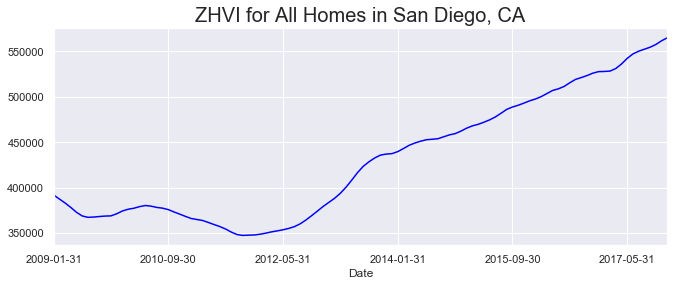

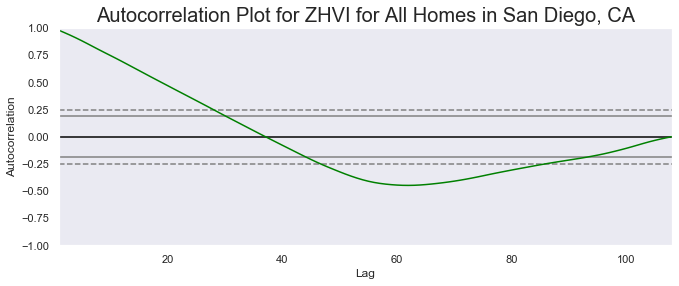

In [271]:
def plot_zhvi(metro):
    single_metro = metro_data.loc[metro_data['MetroName'] == metro]
    single_metro.plot(x = 'Date', color = 'blue', legend = None)
    plt.title('ZHVI for All Homes in ' + metro, fontsize = 20)
    plt.show()
    autocorrelation_plot(single_metro['ZHVI_AllHomes'], color = 'green')
    plt.title('Autocorrelation Plot for ZHVI for All Homes in ' + metro, fontsize = 20)
    
plot_zhvi('San Diego, CA')

## Train ARIMA Model, Calculate Residual Errors and Residual Density

                             ARIMA Model Results                              
Dep. Variable:        D.ZHVI_AllHomes   No. Observations:                  107
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -866.530
Method:                       css-mle   S.D. of innovations            783.851
Date:                Tue, 03 Dec 2019   AIC                           1743.060
Time:                        03:29:04   BIC                           1756.424
Sample:                    02-28-2009   HQIC                          1748.478
                         - 12-31-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1334.7795    955.254      1.397      0.165    -537.484    3207.043
ar.L1.D.ZHVI_AllHomes     1.0404      0.114      9.087      0.000       0.816       1.265
ar.L2.D.

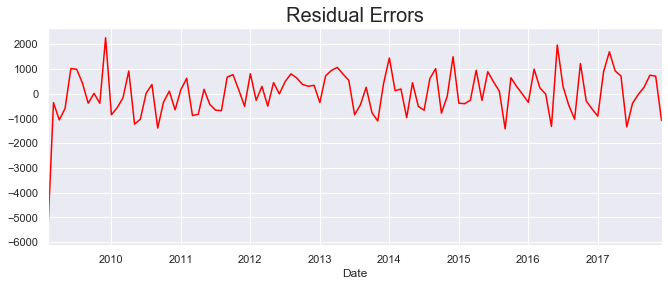

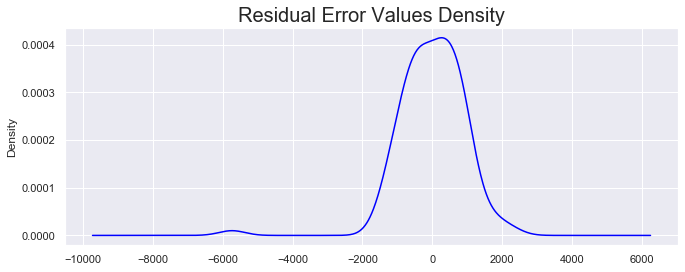

                 0
count   107.000000
mean     -0.596547
std     953.354623
min   -5734.779518
25%    -515.449563
50%      94.818294
75%     636.342513
max    2256.918216


In [272]:
def get_time_series(metro):
    series = metro_data.loc[metro_data['MetroName'] == metro].drop(columns = 'MetroName')
    series = series.set_index('Date')
    series.index = pd.to_datetime(series.index, format ='%Y-%m-%d')
    return series

from statsmodels.tsa.arima_model import ARIMA

series = get_time_series('San Diego, CA')
arima_model = ARIMA(series, order = (2, 1, 1))
arima_model_fit = arima_model.fit(disp = 0)
print(arima_model_fit.summary())

residuals = DataFrame(arima_model_fit.resid)
residuals.plot(color = 'red', legend = None)
plt.title('Residual Errors', fontsize = 20)
plt.show()

residuals.plot(kind = 'kde', color = 'blue', legend = None)
plt.title('Residual Error Values Density', fontsize = 20)
plt.show()
print(residuals.describe())

## Test ARIMA Model

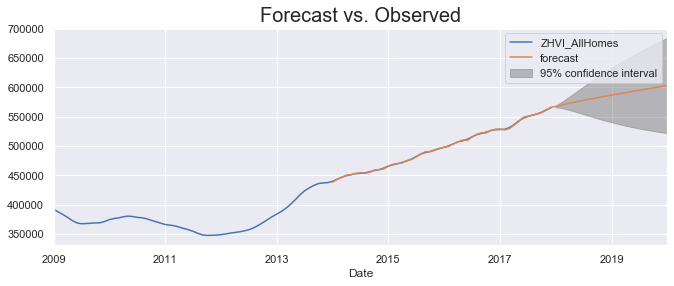

In [268]:
fig, ax = plt.subplots(figsize=(11, 4))
ax = series.loc['2009':].plot(ax = ax)
arima_model_fit.plot_predict('2014', '2020', dynamic=False, ax = ax, plot_insample = False)
plt.title('Forecast vs. Observed', fontsize = 20)
plt.show()

## Quantify Long-Term Recovery with 95% CI

Area of Confidence Interval: 135858.54162054067


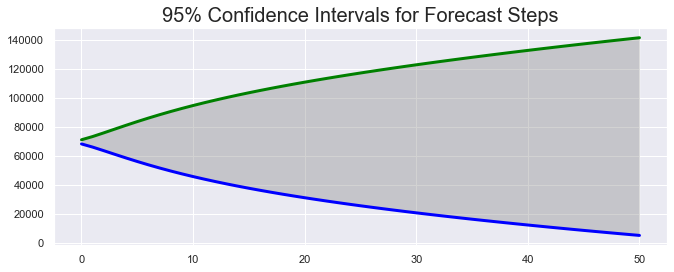

In [262]:
steps = 51
preds, stderr, ci = arima_model_fit.forecast(steps)
lower_bounds = [l[0] for l in ci]
upper_bounds = [u[1] for u in ci]

x = np.arange(steps)
plt.plot(x, lower_bounds, color = 'blue', lw = 3)
plt.plot(x, upper_bounds, color = 'green', lw = 3)
plt.fill_between(x, 
                 lower_bounds, 
                 upper_bounds, 
                 where = upper_bounds >= lower_bounds, 
                 facecolor = 'grey', 
                 alpha = 0.35)
plt.title('95% Confidence Intervals for Forecast Steps', fontsize = 20)

# Calculate the area
z = np.array(lower_bounds) - np.array(upper_bounds)
dx = x[1:] - x[:-1]
area = abs(z[:-1] + z[1:]) * 0.5 * dx
print('Area of Confidence Interval: ' + str(area[len(area) - 1]))

The **smaller** the area of the 95% confidence interval, the **better the recovery over a longer period of time**.